<a href="https://colab.research.google.com/github/Bhargavi1504/Regression-algorithms/blob/main/Decision_tree_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder
import random

np.random.seed(42)
n_samples=1000

#meanures or fraction
missing_fraction = 0.1
duplicate_fraction = 0.05
outlier_fraction = 0.03

#generating functions
def random_generator_of_cat(choice,n_samples):
  return np.random.choice(choice,n_samples)

def generate_dates(n_samples):
  base = datetime.today()
  return [base- timedelta(days=random.randint(0,2000)) for _ in range(n_samples)]


#synthetic data
age=np.random.randint(6,80,n_samples)
experience=np.clip(age-np.random.randint(8,25,n_samples),0,None)
education= random_generator_of_cat(['Bachelors','Masters','PHD'],n_samples)
city = random_generator_of_cat(['New York', 'San Francisco', 'Chicago', 'Austin'],n_samples)
job_role = random_generator_of_cat(['Data Scientist','Data Analyst','Data Engineer'],n_samples)
gender = random_generator_of_cat(['Male', 'Female', 'Other'], n_samples)
join_date = generate_dates(n_samples)
performance = np.random.normal(70,10,n_samples).round(2)
working_hours= np.random.normal(40,5,n_samples).round(1)
married = np.random.choice([0, 1], n_samples)
social_activity = np.random.normal(2, 1, n_samples).round(1)

# Multicollinear & noisy features
salary = experience * 3000 + age* 200 + np.random.normal(0,1000,n_samples)
loan_amount = salary * 0.3 + np.random.normal(0,5000,n_samples)
spending_score= np.random.normal(50,20,n_samples).round(1)
rating = np.random.randint(1, 6, n_samples)
target_salary = salary * 1.1 + np.random.normal(0, 3000, n_samples)
will_churn = np.random.choice([0, 1], n_samples, p=[0.7, 0.3])

#dataframe
d=pd.DataFrame({
    'Age': age,
    'salary': salary.round(2),
    'experience': experience,
    'education_level': education,
    'city': city,
    'job_role': job_role,
    'gender': gender,
    'join_date': join_date,
    'performance': performance,
    'working_hours': working_hours,
    'married': married,
    'loan_amount': loan_amount.round(2),
    'spending_score': spending_score,
    'rating': rating,
    'social_activity': social_activity,
    'target_salary': target_salary.round(2),
    'will_churn': will_churn

})

#inject missing values
for i in d.columns:
  d.loc[d.sample(frac=missing_fraction).index,i]=np.nan

#inject duplicates
num_duplicates=int(n_samples * duplicate_fraction)
duplicate_rows=d.sample(num_duplicates)
d=pd.concat([d,duplicate_rows],ignore_index=True)

#inject outliers
def inject_outliers(d,column,fraction = outlier_fraction,factor=10):
    num_outliers = int(len(d)* fraction)
    indices = np.random.choice(d.index,num_outliers,replace=True)
    d.loc[indices,column] *= factor

inject_outliers(d, 'salary')
inject_outliers(d, 'loan_amount')

#encoded
d_encoded=d.copy()
label_cols= ['education_level', 'city', 'job_role', 'gender']
encoders={}
for c in label_cols:
  le=LabelEncoder()
  d_encoded[c] = d_encoded[c].astype(str) #avoid NaNs
  d_encoded[c]=le.fit_transform(d_encoded[c])
  encoders[c]= le

#saving
d.to_csv("dirty_dataset.csv", index=False)
d_encoded.to_csv("dirty_dataset_encoded.csv", index=False)

print("✅ Dirty dataset and encoded version saved!")

✅ Dirty dataset and encoded version saved!


In [4]:
import pandas as pd

drf = pd.read_csv("dirty_dataset_encoded.csv")
print("Initial Shape:", drf.shape)
drf.head()


Initial Shape: (1050, 17)


,Age,salary,experience,education_level,city,job_role,gender,join_date,performance,working_hours,married,loan_amount,spending_score,rating,social_activity,target_salary,will_churn
0,57.0,115111.40,34.0,0,3,2,2,2024-12-16 17:49:59.432175,82.02,37.3,1.0,NaN,63.1,NaN,1.6,126368.82,0.0
1,20.0,21473.27,5.0,0,1,2,0,2021-02-11 17:49:59.432175,73.17,NaN,1.0,15133.97,NaN,5.0,2.2,22241.01,0.0
2,77.0,222690.26,69.0,3,0,0,1,NaN,69.54,45.4,1.0,70911.69,40.1,2.0,1.4,243407.47,0.0
3,66.0,146046.72,45.0,1,1,1,1,2022-01-20 17:49:59.432175,61.69,37.7,1.0,39256.47,32.4,4.0,1.4,159150.87,0.0
4,26.0,16248.26,4.0,1,2,2,3,2020-07-21 17:49:59.432175,80.95,38.1,1.0,6587.07,56.0,2.0,1.2,14907.01,NaN


In [7]:
#3.1 Drop rows with missing target
drf=drf.dropna(subset=['target_salary'])
print("After dropping null targets:", drf.shape)

After dropping null targets: (941, 17)


In [15]:
#3.2 Impute Missing Values (Median – robust)
from sklearn.impute import SimpleImputer

num_c=drf.select_dtypes(include=['int64','float64']).columns

imputer=SimpleImputer(strategy='median')
drf.loc[:,num_c]=imputer.fit_transform(drf[num_c])

#--cat
drf.loc[:,'join_date']=drf['join_date'].fillna(drf['join_date'].mode()[0])

print('missing values:\n',drf.isnull().sum().sort_values(ascending=False))



missing values:
 Age                0
salary             0
experience         0
education_level    0
city               0
job_role           0
gender             0
join_date          0
performance        0
working_hours      0
married            0
loan_amount        0
spending_score     0
rating             0
social_activity    0
target_salary      0
will_churn         0
dtype: int64


In [16]:
#drop duplicates
drf = drf.drop_duplicates()
print("Shape after duplicate removal:", drf.shape)


Shape after duplicate removal: (902, 17)


In [17]:
drf.dtypes # here all were encoded

,0
Age,float64
salary,float64
experience,float64
education_level,float64
city,float64
job_role,float64
gender,float64
join_date,object
performance,float64
working_hours,float64


In [20]:
#splitting
X = drf.drop(columns=['target_salary', 'will_churn', 'join_date'])
y = drf['target_salary']

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [21]:
#model_training
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

model = DecisionTreeRegressor(random_state=42, max_depth=5)  # Start with controlled depth
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📉 RMSE:", round(rmse, 2))
print("📈 R² Score:", round(r2, 4))


📉 RMSE: 11456.55
📈 R² Score: 0.976


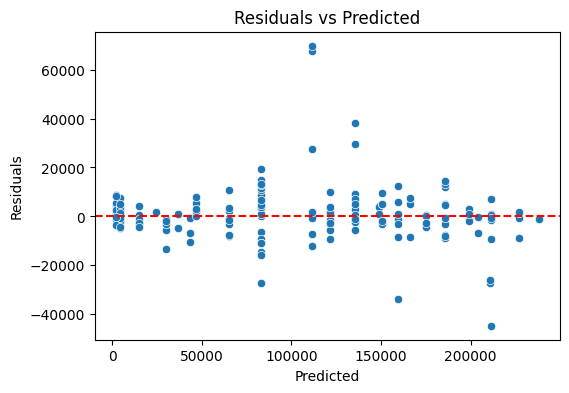

In [22]:
#Residual plot

import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()


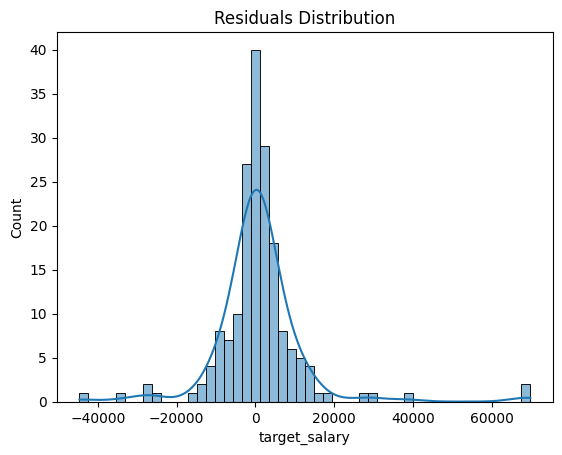

In [23]:
#Residual distribution
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()


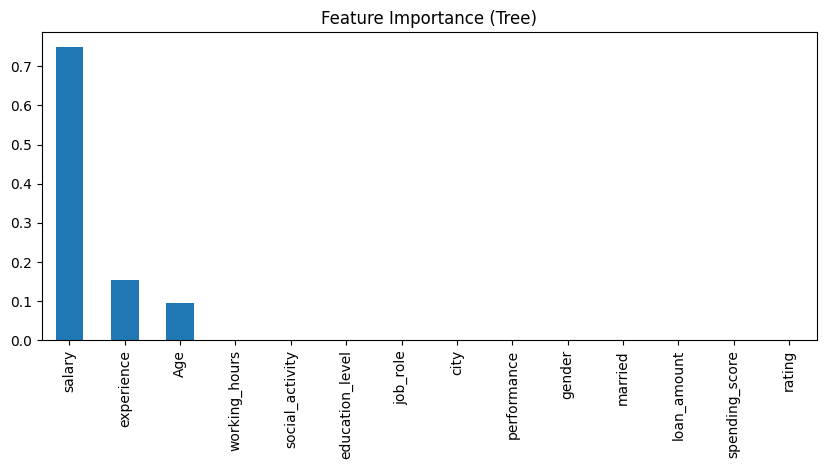

In [25]:
#Step 6: Feature Importance (Native + SHAP)
importances = pd.Series(model.feature_importances_, index=x_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 4), title="Feature Importance (Tree)")
plt.show()


/tmp/ipython-input-26-1278126913.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_train, plot_type="bar")


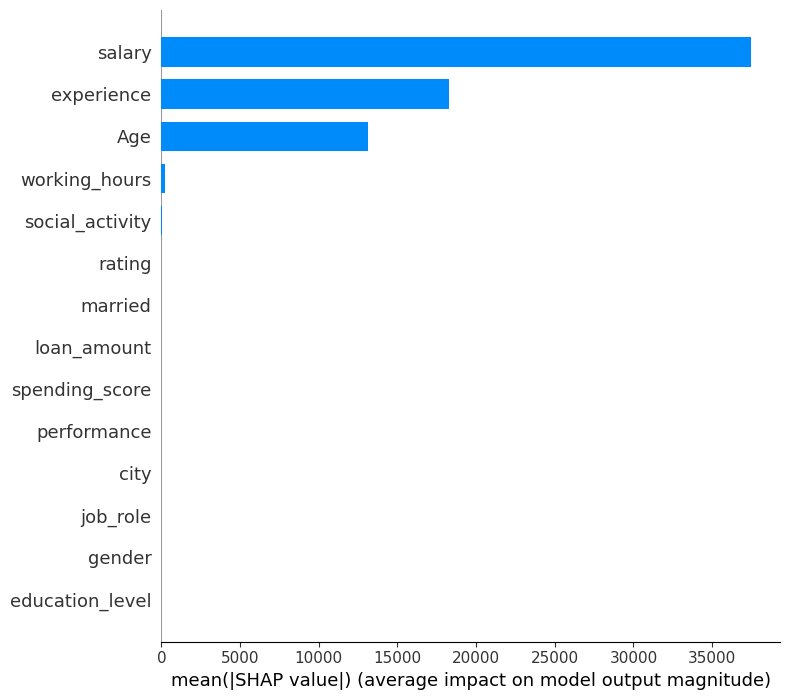

In [26]:
import shap

explainer = shap.Explainer(model, x_train)
shap_values = explainer(x_train)

shap.summary_plot(shap_values, x_train, plot_type="bar")

In [28]:
#Hyperparameter
print("Train Shape:", x_train.shape, "| Test Shape:", x_test.shape)

#GridSearchCV Setup
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Define model and param grid
dt = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [3, 5, 7, 9, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(x_train, y_train)


Train Shape: (721, 14) | Test Shape: (181, 14)
Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, 12],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2', verbose=1)

In [29]:
#Step 3: Best Model & Parameters
best_dt = grid_search.best_estimator_
print("🔍 Best Parameters:", grid_search.best_params_)

#Step 4: Evaluate on Test Set
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred_test = best_dt.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print("📉 Tuned RMSE (Test):", round(rmse, 2))
print("📈 Tuned R² Score (Test):", round(r2, 4))


🔍 Best Parameters: {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2}
📉 Tuned RMSE (Test): 9657.42
📈 Tuned R² Score (Test): 0.9829


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


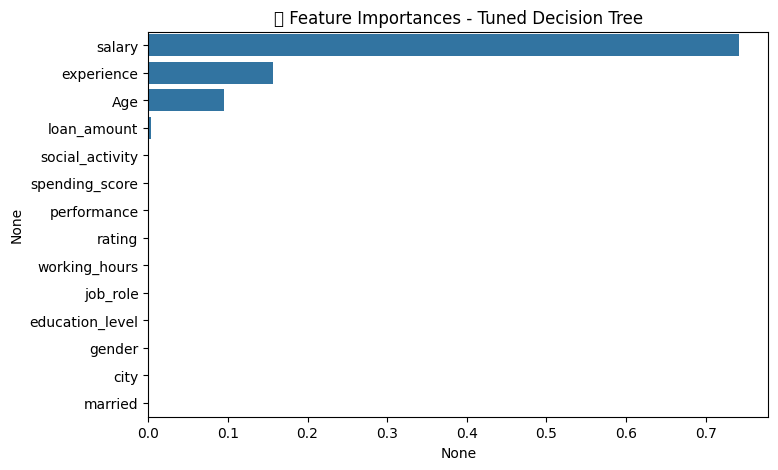

In [30]:
#Step 5: Feature Importance Plot
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(best_dt.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=importances.index)
plt.title("📊 Feature Importances - Tuned Decision Tree")
plt.show()


/tmp/ipython-input-33-3381417713.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_test, plot_type="bar")


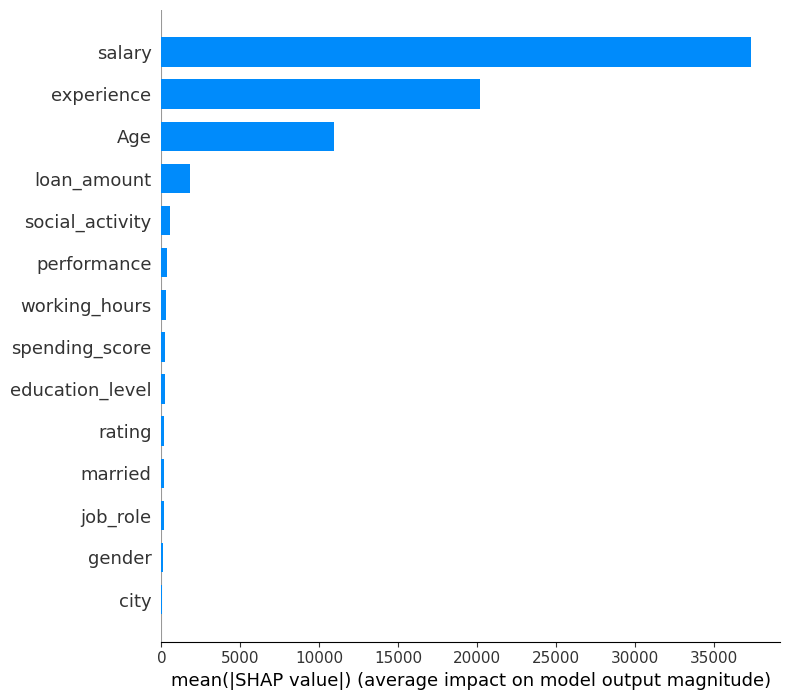

In [33]:
import shap

explainer = shap.Explainer(best_dt, x_test)
shap_values = explainer(x_test)

shap.summary_plot(shap_values, x_test, plot_type="bar")
